In [1577]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [1578]:
data = pd.read_csv('sorghum_2022_whole.csv')

In [1579]:
data =data.loc[data['355'].notnull(), :]

In [1580]:
data = data.loc[data['355']>0 , :]

In [1581]:
data = data.loc[data['1000'] > 0.33 , :]

In [1582]:
data['CHL'] = data[['CHLp1', 'CHLp2', 'CHLp3']].mean(axis=1)

In [1583]:
data.head()

,Genotype ID,Accession,Genotype,Rep,Leaf_num,CHLp1,CHLp2,CHLp3,FW,LA,...,2492,2493,2494,2495,2496,2497,2498,2499,2500,CHL
0,GREENLEAF,PI 659692,1,1,1,367.4,472.9,399.7,4.45,281.59,...,0.071300,0.0707,0.0698,0.069483,0.07050,0.0701,0.0685,0.0683,0.0684,413.333333
1,GREENLEAF,PI 659692,1,1,1,367.4,472.9,399.7,4.45,281.59,...,0.074300,0.0740,0.0743,0.074400,0.07416,0.0736,0.0724,0.0726,0.0741,413.333333
2,GREENLEAF,PI 659692,1,1,1,367.4,472.9,399.7,4.45,281.59,...,0.061000,0.0605,0.0597,0.059500,0.05930,0.0587,0.0582,0.0582,0.0580,413.333333
3,GREENLEAF,PI 659692,1,1,2,399.7,739.3,357.8,3.45,225.36,...,0.075948,0.0754,0.0729,0.072100,0.07200,0.0717,0.0726,0.0726,0.0722,498.933333
4,GREENLEAF,PI 659692,1,1,2,399.7,739.3,357.8,3.45,225.36,...,0.082870,0.0823,0.0813,0.080900,0.07990,0.0796,0.0812,0.0816,0.0816,498.933333


In [1584]:
import copy
data_test = copy.deepcopy(data)

data_test.head()

my_group = data_test.groupby(['Genotype', 'Rep']).mean()

my_group.head()

Leaf_num       CHLp1       CHLp2       CHLp3         FW  \
Genotype Rep                                                            
1        1         2.0  402.100000  524.833333  368.400000   3.183333   
         2         2.0  368.433333  323.066667  254.166667   2.683333   
2        1         1.5  778.500000  750.350000  631.400000  16.000000   
         2         2.0  581.900000  429.000000  216.466667  16.483333   
4        1         2.0  510.433333  557.733333  555.100000  13.833333   

                      LA        DW         SLA       THCK        LWC  ...  \
Genotype Rep                                                          ...   
1        1    210.663333  0.860000  247.273683  68.127403  72.423206  ...   
         2    175.103333  0.700000  255.187200  69.729684  72.802959  ...   
2        1    617.350000  4.215000  146.388094  38.578290  73.639975  ...   
         2    630.256667  4.650000  136.011902  38.322860  71.763973  ...   
4        1    596.180000  4.443333  134.202702  43.024420  67.906064  ...   

                  2492      2493      2494      2495      2496      2497  \
Genotype Rep                                                               
1        1    0.074093  0.073731  0.073122  0.072774  0.072529  0.072144   
         2    0.072218  0.071893  0.071624  0.071518  0.071791  0.071510   
2        1    0.045160  0.044659  0.043533  0.043155  0.042783  0.042633   
         2    0.044433  0.044253  0.043939  0.043714  0.043111  0.042863   
4        1    0.064289  0.064083  0.063794  0.063567  0.063478  0.063435   

                  2498      2499      2500         CHL  
Genotype Rep                                            
1        1    0.071700  0.071611  0.071944  431.777778  
         2    0.070941  0.070632  0.069888  315.222222  
2        1    0.043460  0.043559  0.043034  720.083333  
         2    0.043029  0.043048  0.042944  409.122222  
4        1    0.063330  0.063222  0.063345  541.088889  

[5 rows x 2163 columns]

In [1585]:
my_group = my_group.reset_index()

In [1586]:
y = my_group.loc[: ,'LWC']

In [1587]:
X_total = my_group.iloc[:, 13:2164]

In [1588]:
X_total.drop(columns = X_total.columns[0:100], inplace = True) 

In [1589]:
X_total

,450,451,452,453,454,455,456,457,458,459,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,0.063522,0.063981,0.064120,0.064415,0.064867,0.064756,0.064767,0.065000,0.065256,0.064900,...,0.074209,0.074093,0.073731,0.073122,0.072774,0.072529,0.072144,0.071700,0.071611,0.071944
1,0.083090,0.083374,0.082956,0.082938,0.083556,0.084085,0.084164,0.084198,0.084582,0.084875,...,0.072651,0.072218,0.071893,0.071624,0.071518,0.071791,0.071510,0.070941,0.070632,0.069888
2,0.058764,0.058700,0.058267,0.058035,0.058200,0.058660,0.059227,0.059433,0.059083,0.059113,...,0.045457,0.045160,0.044659,0.043533,0.043155,0.042783,0.042633,0.043460,0.043559,0.043034
3,0.048535,0.048478,0.048178,0.048233,0.048740,0.048918,0.049146,0.049285,0.049167,0.049423,...,0.044278,0.044433,0.044253,0.043939,0.043714,0.043111,0.042863,0.043029,0.043048,0.042944
4,0.068367,0.068070,0.068589,0.069044,0.068944,0.068633,0.068389,0.068796,0.069764,0.069411,...,0.064662,0.064289,0.064083,0.063794,0.063567,0.063478,0.063435,0.063330,0.063222,0.063345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.099893,0.100610,0.101008,0.101394,0.101838,0.102013,0.102350,0.102878,0.103481,0.103581,...,0.087074,0.086616,0.086369,0.085814,0.085228,0.084951,0.084582,0.083503,0.083202,0.083970
116,0.075186,0.075989,0.076267,0.076411,0.076719,0.077338,0.077648,0.077595,0.077472,0.078088,...,0.064874,0.064473,0.064240,0.063900,0.063589,0.063533,0.063400,0.063154,0.063102,0.063589
117,0.084809,0.085060,0.085800,0.086108,0.086063,0.086951,0.087080,0.086999,0.087456,0.087802,...,0.074328,0.074142,0.073891,0.074272,0.074044,0.073078,0.072771,0.072822,0.072533,0.072333
118,0.052522,0.052322,0.052622,0.053099,0.053477,0.053764,0.054113,0.054189,0.053901,0.054333,...,0.070356,0.069540,0.069076,0.068956,0.068625,0.068402,0.068133,0.067705,0.067379,0.067107


In [1590]:
min(X_total['1000'])

0.4131543222222222

([<matplotlib.axis.XTick at 0x7fe11682c760>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

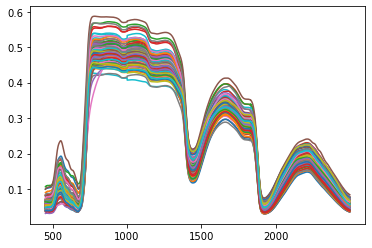

In [1591]:
plt.plot(X_total.T)
plt.xticks(['500', '1000', '1500' , '2000'])

In [1592]:
column_filter = np.arange(0,2050,5)  ## creating an index for column filtering
X= X_total.iloc[:, column_filter] # selecting the filtered columns 

In [1593]:
X[X.isnull().any(axis=1)]

,450,455,460,465,470,475,480,485,490,495,...,2450,2455,2460,2465,2470,2475,2480,2485,2490,2495


In [1594]:
#define the cv
cv = RepeatedKFold(n_splits=10)
rmse = []

In [1595]:
#Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 40):
    pls = PLSRegression(n_components=i)
    score = -1*model_selection.cross_val_score(pls, X, y, cv=cv,
               scoring='neg_mean_squared_error').mean()
    rmse.append(np.sqrt(score))

In [1596]:
n_comp = rmse.index(min(rmse)) +1 

In [1603]:
# split the dataset into training (60%) and testing (40%) sets
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.4) 

In [1604]:
### calculate RMSE
pls = PLSRegression(n_components=n_comp)
pls.fit(X_train, y_train)

PLSRegression(n_components=8)

In [1605]:
np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))

2.3834255591091096

In [1606]:
y_pred = pls.predict(X_test)

<AxesSubplot:xlabel='LWC', ylabel='Predicted CHL values'>

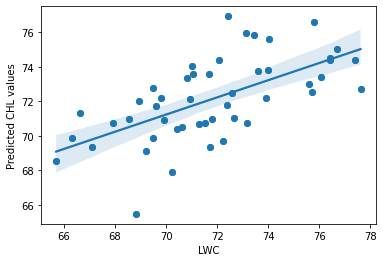

In [1607]:
plt.scatter(y_test, y_pred)
plt.ylabel('Predicted CHL values')
plt.xlabel('Ground truth LWC measurements')
sns.regplot(x = y_test , y = y_pred)

In [1608]:
from scipy.stats import pearsonr, spearmanr
y_pred2 = [x[0] for x in y_pred]

r, p = spearmanr(y_test, y_pred2)
r2 = r**2
print(r2, p)

0.45898712840149414 1.233031029424526e-07
